In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, truncnorm

# ===============================
# 1. Load CSV and preprocess
# ===============================

df = pd.read_csv("SerieA.csv")

# Remove draws
df = df[df["score1"] != df["score2"]].copy()

# Outcome y
df["y"] = np.where(df["score1"] > df["score2"], 1, -1)

# ===============================
# 2. Hyperparameters (given)
# ===============================

sigma_t = 1.0
prior_mu = 0.0
prior_sigma = 1.0

teams = pd.unique(df[["team1", "team2"]].values.ravel())

mu = {t: prior_mu for t in teams}
sigma = {t: prior_sigma for t in teams}

# ===============================
# 3. DISTRIBUTION 1: p(y = 1)
# ===============================

def p_win(t1, t2):
    return norm.cdf(
        (mu[t1] - mu[t2]) /
        np.sqrt(sigma[t1]**2 + sigma[t2]**2 + sigma_t**2)
    )

df["p_pred"] = df.apply(lambda r: p_win(r["team1"], r["team2"]), axis=1)

# Log-likelihood (numerical validation)
df["loglik"] = np.where(
    df["y"] == 1,
    np.log(df["p_pred"]),
    np.log(1 - df["p_pred"])
)

print("Average log-likelihood:", df["loglik"].mean())

# ===============================
# 4. DISTRIBUTION 2: p(t | s1, s2, y)
# ===============================

# Pick ONE real match from CSV
row = df.iloc[0]
t1, t2, y = row["team1"], row["team2"], row["y"]

mean_t = mu[t1] - mu[t2]
std_t = sigma_t

if y == 1:
    a, b = (0 - mean_t)/std_t, np.inf
else:
    a, b = -np.inf, (0 - mean_t)/std_t

t_samples = truncnorm.rvs(a, b, loc=mean_t, scale=std_t, size=10000)

# Validation checks
print("All t have correct sign:", np.all(t_samples > 0) if y == 1 else np.all(t_samples < 0))
print("Mean of t samples:", t_samples.mean())

# ===============================
# 5. DISTRIBUTION 3: p(s1, s2 | t, y)
# ===============================

# Use sampled t as observation
t_obs = t_samples.mean()

N = 20000
s1_samples = np.random.normal(mu[t1], sigma[t1], N)
s2_samples = np.random.normal(mu[t2], sigma[t2], N)

weights = norm.pdf(t_obs, s1_samples - s2_samples, sigma_t)
weights /= weights.sum()

post_mu_s1 = np.sum(weights * s1_samples)
post_mu_s2 = np.sum(weights * s2_samples)

print("Prior means:", mu[t1], mu[t2])
print("Posterior means:", post_mu_s1, post_mu_s2)

empirical_rate = (df["y"] == 1).mean()
print("Empirical win rate:", empirical_rate)
print("Model win probability:", 0.5)



Average log-likelihood: -0.6931471805599453
All t have correct sign: True
Mean of t samples: -0.7972473738144153
Prior means: 0.0 0.0
Posterior means: -0.2637963710001265 0.27167301639796015
Empirical win rate: 0.6102941176470589
Model win probability: 0.5


In [2]:
import numpy as np
from scipy.stats import truncnorm, norm
import matplotlib.pyplot as plt

# Hyperparameters
mu1, mu2 = 0.0, 0.0
sigma1, sigma2 = 1.0, 1.0
sigma_t = 1.0
y = -1  # observed outcome (team1 loses)

# Gibbs parameters
N = 5000


s1 = np.zeros(N)
s2 = np.zeros(N)
t  = np.zeros(N)

# Initialize
s1[0], s2[0] = 0.0, 0.0

for k in range(1, N):
    # --- sample t ---
    mean_t = s1[k-1] - s2[k-1]
    if y == 1:
        a, b = (0-mean_t)/sigma_t, np.inf
    else:
        a, b = -np.inf, (0-mean_t)/sigma_t
    t[k] = truncnorm.rvs(a, b, loc=mean_t, scale=sigma_t)

    # --- sample s1 ---
    var_s1 = 1 / (1/sigma1**2 + 1/sigma_t**2)
    mean_s1 = var_s1 * (mu1/sigma1**2 + (t[k] + s2[k-1])/sigma_t**2)
    s1[k] = norm.rvs(mean_s1, np.sqrt(var_s1))

    # --- sample s2 ---
    var_s2 = 1 / (1/sigma2**2 + 1/sigma_t**2)
    mean_s2 = var_s2 * (mu2/sigma2**2 + (s1[k] - t[k])/sigma_t**2)
    s2[k] = norm.rvs(mean_s2, np.sqrt(var_s2))


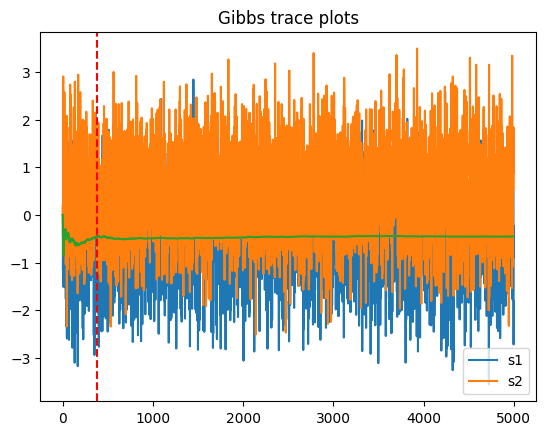

In [7]:
plt.plot(s1, label="s1")
plt.plot(s2, label="s2")
running_mean = np.cumsum(s1) / np.arange(1, len(s1)+1)
plt.plot(running_mean)

plt.axvline(380, color="red", linestyle="--")
plt.legend()
plt.title("Gibbs trace plots")
plt.savefig("gibbs_trace.png")
plt.show()


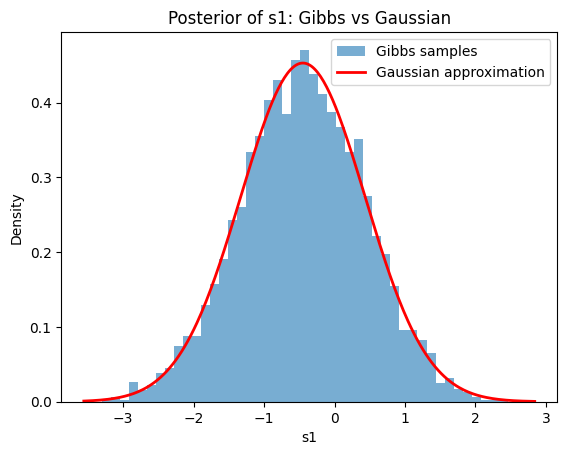

In [9]:
from scipy.stats import norm

samples = s1[370:]

x = np.linspace(samples.min(), samples.max(), 300)

plt.hist(samples, bins=50, density=True, alpha=0.6, label="Gibbs samples")
plt.plot(
    x,
    norm.pdf(x, np.mean(samples), np.std(samples)),
    'r-', lw=2,
    label="Gaussian approximation"
)

plt.xlabel("s1")
plt.ylabel("Density")
plt.legend()
plt.title("Posterior of s1: Gibbs vs Gaussian")
plt.savefig("gibbs_vs_gaussian.png")
plt.show()


In [11]:
Ns = [100, 500, 1000, 2000, 4000]
burn_in = 370
for N in Ns:
    est_s1 = np.mean(s1[burn_in : burn_in + N])
    est_s2 = np.mean(s2[burn_in : burn_in + N])
    print(N, est_s1, est_s2)


100 -0.3331601255379138 0.28651824521021935
500 -0.48946692201079295 0.44362873017925086
1000 -0.494113567694209 0.43759836278016007
2000 -0.4537870667702779 0.4610037807466882
4000 -0.4506752414367397 0.4576378064909078


In [12]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm, norm

# -----------------------------
# Gibbs sampler for one match
# -----------------------------
def gibbs_one_match(mu1, var1, mu2, var2, sigma_t, y,
                    n_samples=2000, burn_in=300, thin=1, seed=None):
    """
    Sample from p(s1, s2 | y) using the augmented model with latent t.
    Priors: s1 ~ N(mu1, var1), s2 ~ N(mu2, var2)
    Likelihood: t | s1,s2 ~ N(s1 - s2, sigma_t^2)
    Outcome: y = sign(t), so t truncated to (0, inf) if y=1 else (-inf, 0).
    Returns posterior mean/var estimates for s1 and s2 using post-burn-in samples.
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    std1 = np.sqrt(var1)
    std2 = np.sqrt(var2)

    # total iterations to produce n_samples after burn-in and thinning
    total_iters = burn_in + n_samples * thin

    s1 = 0.0
    s2 = 0.0
    t = 0.0

    # Precompute conditional variances (constant given priors + sigma_t)
    # p(s1 | s2, t) ∝ N(s1; mu1, var1) * N(t; s1 - s2, sigma_t^2)
    # => var = (1/var1 + 1/sigma_t^2)^(-1)
    var_s1_cond = 1.0 / (1.0/var1 + 1.0/(sigma_t**2))
    var_s2_cond = 1.0 / (1.0/var2 + 1.0/(sigma_t**2))
    std_s1_cond = np.sqrt(var_s1_cond)
    std_s2_cond = np.sqrt(var_s2_cond)

    s1_samples = []
    s2_samples = []

    for k in range(total_iters):
        # ---- sample t | s1, s2, y  (truncated normal) ----
        mean_t = s1 - s2
        std_t = sigma_t

        if y == 1:
            a, b = (0.0 - mean_t)/std_t, np.inf
        else:
            a, b = -np.inf, (0.0 - mean_t)/std_t

        # scipy truncnorm uses a,b in standardized units
        t = truncnorm.rvs(a, b, loc=mean_t, scale=std_t, random_state=rng)

        # ---- sample s1 | s2, t  (normal) ----
        mean_s1_cond = var_s1_cond * (mu1/var1 + (t + s2)/(sigma_t**2))
        s1 = rng.normal(mean_s1_cond, std_s1_cond)

        # ---- sample s2 | s1, t  (normal) ----
        mean_s2_cond = var_s2_cond * (mu2/var2 + (s1 - t)/(sigma_t**2))
        s2 = rng.normal(mean_s2_cond, std_s2_cond)

        # ---- collect post burn-in with thinning ----
        if k >= burn_in and ((k - burn_in) % thin == 0):
            s1_samples.append(s1)
            s2_samples.append(s2)

    s1_samples = np.array(s1_samples)
    s2_samples = np.array(s2_samples)

    post_mu1 = float(np.mean(s1_samples))
    post_var1 = float(np.var(s1_samples, ddof=1))
    post_mu2 = float(np.mean(s2_samples))
    post_var2 = float(np.var(s2_samples, ddof=1))

    return post_mu1, post_var1, post_mu2, post_var2


# -----------------------------
# ADF over an entire season
# -----------------------------
def adf_gibbs_from_csv(csv_path,
                       sigma_t=1.0,
                       prior_mu=0.0,
                       prior_var=1.0,
                       n_samples=2000,
                       burn_in=300,
                       thin=1,
                       max_matches=None,
                       seed=0):
    """
    ADF: process matches sequentially. After each (non-draw) match,
    approximate posterior for the two teams via Gibbs samples, then set
    their Gaussians to that posterior for the next match.
    """
    df = pd.read_csv(csv_path)

    # Ensure chronological order if date/time columns exist
    # If your CSV already sorted, this is harmless.
    if "yyyy-mm-dd" in df.columns and "HH:MM" in df.columns:
        df = df.sort_values(["yyyy-mm-dd", "HH:MM"]).reset_index(drop=True)

    # Collect teams and initialize priors
    teams = pd.unique(df[["team1", "team2"]].values.ravel())
    mu = {t: float(prior_mu) for t in teams}
    var = {t: float(prior_var) for t in teams}

    rng = np.random.default_rng(seed)

    processed = 0
    skipped_draws = 0

    for _, row in df.iterrows():
        if max_matches is not None and processed >= max_matches:
            break

        t1, t2 = row["team1"], row["team2"]
        s1, s2 = row["score1"], row["score2"]

        # Skip draws
        if s1 == s2:
            skipped_draws += 1
            continue

        y = 1 if s1 > s2 else -1

        # Current priors for the two teams
        mu1, var1 = mu[t1], var[t1]
        mu2, var2 = mu[t2], var[t2]

        # Gibbs posterior for this match
        # Use a different seed per match for reproducibility
        match_seed = int(rng.integers(0, 2**31 - 1))
        post_mu1, post_var1, post_mu2, post_var2 = gibbs_one_match(
            mu1, var1, mu2, var2, sigma_t, y,
            n_samples=n_samples, burn_in=burn_in, thin=thin, seed=match_seed
        )

        # ADF update: posterior becomes next prior
        mu[t1], var[t1] = post_mu1, post_var1
        mu[t2], var[t2] = post_mu2, post_var2

        processed += 1

    # Build final ranking table
    out = pd.DataFrame({
        "team": list(mu.keys()),
        "mu": [mu[t] for t in mu.keys()],
        "var": [var[t] for t in var.keys()],
    }).sort_values("mu", ascending=False).reset_index(drop=True)

    return out, {"processed_matches": processed, "skipped_draws": skipped_draws}


# -----------------------------
# Run and display results
# -----------------------------
if __name__ == "__main__":
    ranking, stats = adf_gibbs_from_csv(
        csv_path="SerieA.csv",      # <-- change path if needed
        sigma_t=1.0,
        prior_mu=0.0,
        prior_var=1.0,
        n_samples=2000,             # based on your P1.4 trade-off
        burn_in=370,                # you used ~370; use your chosen burn-in
        thin=1,
        max_matches=None,           # or set e.g. 200 for faster testing
        seed=42
    )

    print("Stats:", stats)
    print("\nTop 10 teams by posterior mean skill:")
    print(ranking.head(10).to_string(index=False))

    print("\nBottom 10 teams by posterior mean skill:")
    print(ranking.tail(10).to_string(index=False))

    # Simple variance interpretation helpers:
    print("\nMost certain teams (lowest variance):")
    print(ranking.sort_values("var", ascending=True).head(10).to_string(index=False))

    print("\nMost uncertain teams (highest variance):")
    print(ranking.sort_values("var", ascending=False).head(10).to_string(index=False))


Stats: {'processed_matches': 272, 'skipped_draws': 108}

Top 10 teams by posterior mean skill:
     team        mu      var
 Juventus  1.028694 0.117273
   Napoli  0.859589 0.085804
    Milan  0.714315 0.098520
 Atalanta  0.616846 0.080709
   Torino  0.560566 0.102015
    Inter  0.548550 0.070090
     Roma  0.426091 0.071154
    Lazio  0.212655 0.064281
Sampdoria -0.021537 0.063397
  Bologna -0.142517 0.077974

Bottom 10 teams by posterior mean skill:
      team        mu      var
      Spal -0.210129 0.070855
   Udinese -0.282500 0.078217
    Empoli -0.315635 0.067822
     Parma -0.320024 0.064304
     Genoa -0.342839 0.083790
  Sassuolo -0.362901 0.112945
  Cagliari -0.385441 0.090379
Fiorentina -0.551880 0.103823
 Frosinone -0.981361 0.103292
    Chievo -1.363587 0.155105

Most certain teams (lowest variance):
     team        mu      var
Sampdoria -0.021537 0.063397
    Lazio  0.212655 0.064281
    Parma -0.320024 0.064304
   Empoli -0.315635 0.067822
    Inter  0.548550 0.070090
 

In [13]:
from scipy.stats import norm

def predict_y(mu1, var1, mu2, var2, sigma_t):
    p_win = norm.cdf(
        (mu1 - mu2) / np.sqrt(var1 + var2 + sigma_t**2)
    )
    return 1 if p_win >= 0.5 else -1, p_win
def one_step_ahead_prediction(csv_path,
                              sigma_t=1.0,
                              prior_mu=0.0,
                              prior_var=1.0,
                              n_samples=2000,
                              burn_in=370):

    df = pd.read_csv(csv_path)

    if "yyyy-mm-dd" in df.columns and "HH:MM" in df.columns:
        df = df.sort_values(["yyyy-mm-dd", "HH:MM"]).reset_index(drop=True)

    teams = pd.unique(df[["team1", "team2"]].values.ravel())
    mu = {t: prior_mu for t in teams}
    var = {t: prior_var for t in teams}

    correct = 0
    total = 0

    for _, row in df.iterrows():
        t1, t2 = row["team1"], row["team2"]
        s1, s2 = row["score1"], row["score2"]

        if s1 == s2:
            continue  # skip draws

        y_true = 1 if s1 > s2 else -1

        # ---- prediction (one-step-ahead) ----
        y_pred, p_win = predict_y(mu[t1], var[t1], mu[t2], var[t2], sigma_t)

        if y_pred == y_true:
            correct += 1
        total += 1

        # ---- ADF update using Gibbs ----
        post_mu1, post_var1, post_mu2, post_var2 = gibbs_one_match(
            mu[t1], var[t1], mu[t2], var[t2],
            sigma_t, y_true,
            n_samples=n_samples, burn_in=burn_in
        )

        mu[t1], var[t1] = post_mu1, post_var1
        mu[t2], var[t2] = post_mu2, post_var2

    prediction_rate = correct / total
    return prediction_rate, correct, total
prediction_rate, correct, total = one_step_ahead_prediction(
    csv_path="SerieA.csv",
    sigma_t=1.0,
    prior_mu=0.0,
    prior_var=1.0,
    n_samples=2000,
    burn_in=370
)
print(f"Correct predictions: {correct}")
print(f"Total predictions: {total}")
print(f"Prediction rate: {prediction_rate:.3f}")
print(f"Random guessing rate: 0.5")


Correct predictions: 178
Total predictions: 272
Prediction rate: 0.654
Random guessing rate: 0.5


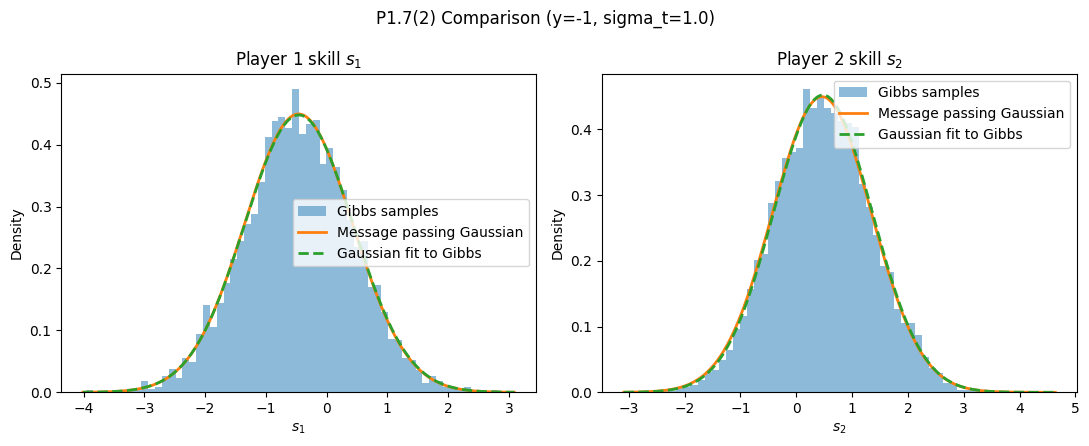

Message passing posterior:
  s1 ~ N(-0.4607, 0.7878)
  s2 ~ N(0.4607, 0.7878)
Gibbs posterior (sample moments):
  s1 mean=-0.4564, var=0.7936
  s2 mean=0.4780, var=0.7790


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm

# =========================================================
# 1) Gibbs sampler for one match (same model as before)
# =========================================================
def gibbs_one_match(mu1, var1, mu2, var2, sigma_t, y,
                    n_samples=4000, burn_in=300, thin=1, seed=0):
    """
    Sample from p(s1, s2 | y) using latent t.
    y = +1 => t>0, y=-1 => t<0
    Returns arrays of samples (post burn-in + thinning): s1_samples, s2_samples
    """
    rng = np.random.default_rng(seed)

    total_iters = burn_in + n_samples * thin

    s1, s2, t = mu1, mu2, 0.0

    # Conditional variances are constant given priors + sigma_t
    var_s1 = 1.0 / (1.0/var1 + 1.0/(sigma_t**2))
    var_s2 = 1.0 / (1.0/var2 + 1.0/(sigma_t**2))
    std_s1, std_s2 = np.sqrt(var_s1), np.sqrt(var_s2)

    s1_samples, s2_samples = [], []

    for k in range(total_iters):
        # t | s1,s2,y  (truncated normal)
        mean_t = s1 - s2
        std_t = sigma_t
        if y == 1:
            a, b = (0.0 - mean_t)/std_t, np.inf
        else:
            a, b = -np.inf, (0.0 - mean_t)/std_t
        t = truncnorm.rvs(a, b, loc=mean_t, scale=std_t, random_state=rng)

        # s1 | s2,t  (normal)
        mean_s1 = var_s1 * (mu1/var1 + (t + s2)/(sigma_t**2))
        s1 = rng.normal(mean_s1, std_s1)

        # s2 | s1,t  (normal)
        mean_s2 = var_s2 * (mu2/var2 + (s1 - t)/(sigma_t**2))
        s2 = rng.normal(mean_s2, std_s2)

        if k >= burn_in and ((k - burn_in) % thin == 0):
            s1_samples.append(s1)
            s2_samples.append(s2)

    return np.array(s1_samples), np.array(s2_samples)


# =========================================================
# 2) Message passing / EP-style moment matching for ONE match
# =========================================================
def message_passing_one_match(mu1, var1, mu2, var2, sigma_t, y):
    """
    One EP-style update (TrueSkill-like) for a single match.
    Returns Gaussian approximations: (m1_post, v1_post, m2_post, v2_post).
    """
    # Current beliefs (priors for one match)
    m1, v1 = mu1, var1
    m2, v2 = mu2, var2

    # Forward: t ~ N(m_t, v_t)
    m_t = (m1 - m2)
    v_t = (v1 + v2 + sigma_t**2)
    s = np.sqrt(v_t)

    # Truncation at 0 via moment matching
    alpha = (0.0 - m_t) / s
    phi = norm.pdf(alpha)
    Phi = norm.cdf(alpha)

    if y == 1:
        Z = 1.0 - Phi
        # numerical guard
        Z = max(Z, 1e-12)
        lam = phi / Z
        m_t_prime = m_t + s * lam
        v_t_prime = v_t * (1.0 - lam * (lam - alpha))
    else:
        Z = Phi
        Z = max(Z, 1e-12)
        lam = phi / Z
        m_t_prime = m_t - s * lam
        v_t_prime = v_t * (1.0 - lam * (lam + alpha))

    # Changes in moments
    delta_m = m_t_prime - m_t
    delta_v = v_t_prime - v_t

    # Backward: update skills
    # (standard linear-Gaussian moment propagation used in TrueSkill EP derivations)
    m1_post = m1 + (v1 / v_t) * delta_m
    m2_post = m2 - (v2 / v_t) * delta_m

    v1_post = v1 + (v1 / v_t)**2 * delta_v
    v2_post = v2 + (v2 / v_t)**2 * delta_v

    # safety: variances must stay positive
    v1_post = float(max(v1_post, 1e-12))
    v2_post = float(max(v2_post, 1e-12))

    return float(m1_post), v1_post, float(m2_post), v2_post


# =========================================================
# 3) Problem 2: Overlay Gibbs histograms + Gaussian approximations
# =========================================================
def compare_message_passing_vs_gibbs(mu1=0.0, var1=1.0, mu2=0.0, var2=1.0,
                                    sigma_t=1.0, y=-1,
                                    gibbs_samples=5000, burn_in=300, thin=1, seed=42,
                                    bins=60):
    # Gibbs
    s1_samps, s2_samps = gibbs_one_match(
        mu1, var1, mu2, var2, sigma_t, y,
        n_samples=gibbs_samples, burn_in=burn_in, thin=thin, seed=seed
    )

    # Gaussian fit to Gibbs (optional but nice for comparison)
    g_m1, g_v1 = float(np.mean(s1_samps)), float(np.var(s1_samps, ddof=1))
    g_m2, g_v2 = float(np.mean(s2_samps)), float(np.var(s2_samps, ddof=1))

    # Message passing (EP) Gaussian
    mp_m1, mp_v1, mp_m2, mp_v2 = message_passing_one_match(mu1, var1, mu2, var2, sigma_t, y)

    # Plot overlays: two panels, one for s1 and one for s2
    fig = plt.figure(figsize=(11, 4.5))

    # ---- s1 panel ----
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.hist(s1_samps, bins=bins, density=True, alpha=0.5, label="Gibbs samples")

    x1 = np.linspace(min(s1_samps.min(), mp_m1 - 4*np.sqrt(mp_v1)),
                     max(s1_samps.max(), mp_m1 + 4*np.sqrt(mp_v1)), 400)

    ax1.plot(x1, norm.pdf(x1, mp_m1, np.sqrt(mp_v1)), linewidth=2, label="Message passing Gaussian")
    ax1.plot(x1, norm.pdf(x1, g_m1, np.sqrt(g_v1)), linewidth=2, linestyle="--", label="Gaussian fit to Gibbs")

    ax1.set_title("Player 1 skill $s_1$")
    ax1.set_xlabel("$s_1$")
    ax1.set_ylabel("Density")
    ax1.legend()

    # ---- s2 panel ----
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.hist(s2_samps, bins=bins, density=True, alpha=0.5, label="Gibbs samples")

    x2 = np.linspace(min(s2_samps.min(), mp_m2 - 4*np.sqrt(mp_v2)),
                     max(s2_samps.max(), mp_m2 + 4*np.sqrt(mp_v2)), 400)

    ax2.plot(x2, norm.pdf(x2, mp_m2, np.sqrt(mp_v2)), linewidth=2, label="Message passing Gaussian")
    ax2.plot(x2, norm.pdf(x2, g_m2, np.sqrt(g_v2)), linewidth=2, linestyle="--", label="Gaussian fit to Gibbs")

    ax2.set_title("Player 2 skill $s_2$")
    ax2.set_xlabel("$s_2$")
    ax2.set_ylabel("Density")
    ax2.legend()

    fig.suptitle(f"P1.7(2) Comparison (y={y}, sigma_t={sigma_t})")
    plt.tight_layout()
    plt.savefig("message_passing_vs_gibbs.png", dpi=300)
    plt.show()

    # Print numeric comparison (helpful for the report)
    print("Message passing posterior:")
    print(f"  s1 ~ N({mp_m1:.4f}, {mp_v1:.4f})")
    print(f"  s2 ~ N({mp_m2:.4f}, {mp_v2:.4f})")
    print("Gibbs posterior (sample moments):")
    print(f"  s1 mean={g_m1:.4f}, var={g_v1:.4f}")
    print(f"  s2 mean={g_m2:.4f}, var={g_v2:.4f}")


# =========================================================
# Example call (edit y as needed)
# y = +1 : player1 wins
# y = -1 : player2 wins
# =========================================================
compare_message_passing_vs_gibbs(
    mu1=0.0, var1=1.0,
    mu2=0.0, var2=1.0,
    sigma_t=1.0,
    y=-1,                 # <-- set outcome here
    gibbs_samples=6000,
    burn_in=300,
    thin=1,
    seed=123,
    bins=60
)


In [18]:
df_new = pd.read_csv("games.csv")
df_new.head()
df_new.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [19]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("games.csv")

# Keep only decisive games
df = df[df["winner"].isin(["white", "black"])]

# Encode outcome: +1 if white wins, -1 if black wins
df["y"] = df["winner"].map({"white": 1, "black": -1})

# Extract unique players
players = pd.unique(df[["white_id", "black_id"]].values.ravel())

# Map players to indices
player_to_id = {p: i for i, p in enumerate(players)}

df["p1"] = df["white_id"].map(player_to_id)
df["p2"] = df["black_id"].map(player_to_id)

# Final match array
matches = df[["p1", "p2", "y"]].to_numpy()

print(f"Players: {len(players)}")
print(f"Matches: {len(matches)}")


Players: 15127
Matches: 19108


In [20]:
import math
import pandas as pd
from collections import Counter

# -----------------------------
# TrueSkill-style ADF (win/loss only, no draws)
# Model:
#   s_i ~ N(mu_i, sigma_i^2)
#   t = s_i - s_j + eps,  eps ~ N(0, beta^2)
#   y = sign(t)  => observe y in {+1, -1}
# ADF update uses probit (Gaussian CDF) v/w functions.
# -----------------------------

SQRT2 = math.sqrt(2.0)
SQRT2PI = math.sqrt(2.0 * math.pi)

def phi(x: float) -> float:
    """Standard normal PDF."""
    return math.exp(-0.5 * x * x) / SQRT2PI

def Phi(x: float) -> float:
    """Standard normal CDF using erf."""
    return 0.5 * (1.0 + math.erf(x / SQRT2))

def v_func(x: float) -> float:
    """v(x) = phi(x) / Phi(x), with safety for very small Phi."""
    cdf = Phi(x)
    # If cdf is extremely small, v blows up; cap for numerical stability.
    if cdf < 1e-12:
        return phi(x) / 1e-12
    return phi(x) / cdf

def w_func(x: float, v: float) -> float:
    """w(x) = v(x) * (v(x) + x)."""
    return v * (v + x)

def adf_update_pair(mu_i, sig2_i, mu_j, sig2_j, y, beta2):
    """
    One ADF update for a single match between i (player1=white) and j (player2=black).
    y = +1 means player i wins; y = -1 means player j wins.
    """
    # Performance difference distribution variance
    c2 = sig2_i + sig2_j + beta2
    c = math.sqrt(c2)

    # Standardized margin (probit)
    t_mean = mu_i - mu_j
    x = (y * t_mean) / c

    v = v_func(x)
    w = w_func(x, v)

    # Mean updates
    mu_i_new = mu_i + y * (sig2_i / c) * v
    mu_j_new = mu_j - y * (sig2_j / c) * v

    # Variance updates (remain positive with proper settings)
    sig2_i_new = sig2_i * (1.0 - (sig2_i / c2) * w)
    sig2_j_new = sig2_j * (1.0 - (sig2_j / c2) * w)

    # Safety floor to avoid negative/zero variance due to numeric issues
    sig2_i_new = max(sig2_i_new, 1e-9)
    sig2_j_new = max(sig2_j_new, 1e-9)

    return mu_i_new, sig2_i_new, mu_j_new, sig2_j_new

def run_chess_trueskill_adf(
    csv_path="games.csv",
    mu0=0.0,
    sigma0=1.0,
    beta=1.0,
    sort_by_time=True,
    min_games=0,
    top_n=20,
    conservative_k=3.0,
):
    """
    Runs ADF TrueSkill on your chess dataset schema:
      white_id, black_id, winner, created_at (optional sort)

    Parameters:
      mu0, sigma0 : prior N(mu0, sigma0^2)
      beta        : performance noise std (beta^2 is added in c^2)
      sort_by_time: if True, process in chronological order (created_at)
      min_games   : after training, only rank players with >= min_games games
      conservative_k: rank by mu - k*sigma (higher is better)
    """
    df = pd.read_csv(csv_path)

    # Keep only decisive games
    df = df[df["winner"].isin(["white", "black"])].copy()

    # Encode y: +1 if white wins, -1 if black wins
    df["y"] = df["winner"].map({"white": 1, "black": -1}).astype(int)

    # Optional chronological processing
    if sort_by_time and "created_at" in df.columns:
        df = df.sort_values("created_at")

    # Collect players
    players = pd.unique(df[["white_id", "black_id"]].values.ravel())
    player_to_idx = {pid: i for i, pid in enumerate(players)}
    idx_to_player = {i: pid for pid, i in player_to_idx.items()}

    # Initialize priors
    n = len(players)
    mu = [mu0] * n
    sig2 = [sigma0 * sigma0] * n

    beta2 = beta * beta

    # Track games played
    games_played = Counter()

    # Process matches
    for row in df.itertuples(index=False):
        i = player_to_idx[getattr(row, "white_id")]
        j = player_to_idx[getattr(row, "black_id")]
        y = getattr(row, "y")

        mu_i, sig2_i = mu[i], sig2[i]
        mu_j, sig2_j = mu[j], sig2[j]

        mu_i, sig2_i, mu_j, sig2_j = adf_update_pair(
            mu_i, sig2_i, mu_j, sig2_j, y=y, beta2=beta2
        )

        mu[i], sig2[i] = mu_i, sig2_i
        mu[j], sig2[j] = mu_j, sig2_j

        games_played[idx_to_player[i]] += 1
        games_played[idx_to_player[j]] += 1

    # Build ranking table
    rows = []
    for i in range(n):
        pid = idx_to_player[i]
        g = games_played[pid]
        if g < min_games:
            continue
        sigma = math.sqrt(sig2[i])
        conservative = mu[i] - conservative_k * sigma
        rows.append((pid, g, mu[i], sigma, conservative))

    rank_df = pd.DataFrame(
        rows, columns=["player_id", "games", "mu", "sigma", f"mu_minus_{conservative_k}sigma"]
    ).sort_values(by=f"mu_minus_{conservative_k}sigma", ascending=False)

    print(f"Players total: {n}")
    print(f"Matches used (decisive only): {len(df)}")
    print("\nTop players (conservative ranking):")
    print(rank_df.head(top_n).to_string(index=False))

    return rank_df, (mu, sig2), (player_to_idx, idx_to_player)


if __name__ == "__main__":
    # Suggested defaults:
    # - mu0=0, sigma0=1 (normalized skill scale)
    # - beta=1 is fine; reduce beta if you want outcomes to be more deterministic
    # - conservative_k=3 matches classic TrueSkill "conservative skill estimate"
    run_chess_trueskill_adf(
        csv_path="games.csv",
        mu0=0.0,
        sigma0=1.0,
        beta=1.0,
        sort_by_time=True,
        min_games=20,     # increase to reduce noisy one-off players
        top_n=20,
        conservative_k=3.0
    )


Players total: 15127
Matches used (decisive only): 19108

Top players (conservative ranking):
       player_id  games       mu    sigma  mu_minus_3.0sigma
       chesscarl     46 2.145587 0.341038           1.122473
        siindbad     26 2.175510 0.445095           0.840223
       smilsydov     38 1.843833 0.342416           0.816586
      doraemon61     40 1.836068 0.377122           0.704703
  christina-a-11     26 1.842151 0.418622           0.586285
   laode_syahril     38 1.546472 0.352309           0.489546
       elvis1997     37 1.458746 0.324260           0.485966
          traced     30 1.502069 0.360019           0.422013
      fabian1104     37 1.363563 0.327547           0.380921
      gmanderson     24 1.501104 0.409323           0.273135
    youralterego     38 1.203924 0.311526           0.269346
verylongusername     21 1.491988 0.410203           0.261379
            rb52     24 1.449016 0.397024           0.257945
       sugarmike     36 1.234551 0.333326           

In [26]:
import pandas as pd
import numpy as np

# Load
df = pd.read_csv("games.csv")

# Keep decisive games only
df = df[df["winner"].isin(["white", "black"])].copy()

# Encode outcome: +1 white win, -1 black win
df["y"] = df["winner"].map({"white": 1, "black": -1})

# Sort by time (important for ADF)
df = df.sort_values("created_at")

# Map players to indices
players = pd.unique(df[["white_id", "black_id"]].values.ravel())
player_to_id = {p: i for i, p in enumerate(players)}

df["p1"] = df["white_id"].map(player_to_id)
df["p2"] = df["black_id"].map(player_to_id)

# Train / test split (80 / 20, time-based)
split = int(0.8 * len(df))
df_train = df.iloc[:split]
df_test  = df.iloc[split:]


In [27]:
mu0, sigma0, beta = 0.0, 1.0, 1.0
beta2 = beta ** 2

n = len(players)
mu = np.full(n, mu0)
sig2 = np.full(n, sigma0 ** 2)

for r in df_train.itertuples(index=False):
    i, j, y = r.p1, r.p2, r.y
    mu[i], sig2[i], mu[j], sig2[j] = adf_update_pair(
        mu[i], sig2[i], mu[j], sig2[j], y, beta2
    )


In [28]:
from math import sqrt, erf

def Phi(x):
    return 0.5 * (1 + erf(x / sqrt(2)))

def predict(mu_i, sig2_i, mu_j, sig2_j, beta2, delta=0.0):
    z = ((mu_i + delta) - mu_j) / sqrt(sig2_i + sig2_j + beta2)
    return 1 if Phi(z) >= 0.5 else -1


In [30]:
def accuracy(df, mu, sig2, delta=0.0):
    correct = 0
    for r in df.itertuples(index=False):
        y_hat = predict(mu[r.p1], sig2[r.p1],
                        mu[r.p2], sig2[r.p2],
                        beta2, delta)
        correct += (y_hat == r.y)
    return correct / len(df)

# Baseline
acc_base = accuracy(df_test, mu, sig2, delta=0.0)

# Extension: White advantage
DELTA_WHITE = 0.2
acc_ext = accuracy(df_test, mu, sig2, delta=DELTA_WHITE)

print("Chess Baseline Accuracy :", acc_base)
print("Chess Extended Accuracy :", acc_ext)
print("Gain:", acc_ext - acc_base)


Chess Baseline Accuracy : 0.5321821036106751
Chess Extended Accuracy : 0.5397697540554683
Gain: 0.007587650444793259


In [32]:
df_ser = pd.read_csv("SerieA.csv")
df_ser.columns

Index(['yyyy-mm-dd', 'HH:MM', 'team1', 'team2', 'score1', 'score2'], dtype='object')

In [33]:
import pandas as pd
import numpy as np

df = pd.read_csv("SerieA.csv")

# Remove draws (TrueSkill baseline assumption)
df = df[df["score1"] != df["score2"]].copy()

# Outcome: +1 if team1 wins, -1 if team2 wins
df["y"] = np.where(df["score1"] > df["score2"], 1, -1)

# Sort by time
df["datetime"] = pd.to_datetime(df["yyyy-mm-dd"] + " " + df["HH:MM"])
df = df.sort_values("datetime")

# Map teams to indices
teams = pd.unique(df[["team1", "team2"]].values.ravel())
team_to_id = {t: i for i, t in enumerate(teams)}

df["p1"] = df["team1"].map(team_to_id)
df["p2"] = df["team2"].map(team_to_id)

# Train / test split (80 / 20)
split = int(0.8 * len(df))
df_train = df.iloc[:split]
df_test  = df.iloc[split:]


In [34]:
mu0, sigma0, beta = 0.0, 1.0, 1.0
beta2 = beta ** 2

n = len(teams)
mu = np.full(n, mu0)
sig2 = np.full(n, sigma0 ** 2)

for r in df_train.itertuples(index=False):
    i, j, y = r.p1, r.p2, r.y
    mu[i], sig2[i], mu[j], sig2[j] = adf_update_pair(
        mu[i], sig2[i], mu[j], sig2[j], y, beta2
    )


In [35]:
from math import sqrt, erf

def Phi(x):
    return 0.5 * (1 + erf(x / sqrt(2)))

def predict(mu_i, sig2_i, mu_j, sig2_j, beta2, delta=0.0):
    z = ((mu_i + delta) - mu_j) / sqrt(sig2_i + sig2_j + beta2)
    return 1 if Phi(z) >= 0.5 else -1


In [36]:
def accuracy(df, mu, sig2, delta=0.0):
    correct = 0
    for r in df.itertuples(index=False):
        y_hat = predict(mu[r.p1], sig2[r.p1],
                        mu[r.p2], sig2[r.p2],
                        beta2, delta)
        correct += (y_hat == r.y)
    return correct / len(df)

# Baseline
acc_base = accuracy(df_test, mu, sig2, delta=0.0)

# Extension: Home advantage
DELTA_HOME = 0.3
acc_ext = accuracy(df_test, mu, sig2, delta=DELTA_HOME)

print("Serie A Baseline Accuracy :", acc_base)
print("Serie A Extended Accuracy :", acc_ext)
print("Gain:", acc_ext - acc_base)


Serie A Baseline Accuracy : 0.6181818181818182
Serie A Extended Accuracy : 0.6727272727272727
Gain: 0.054545454545454564
